In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv("sample_submission.csv")

In [ ]:
train['Date'] = pd.to_datetime(train['Date'], format='%d-%m-%Y')
test['Date'] = pd.to_datetime(test['Date'], format='%d-%m-%Y')


In [ ]:
train_arrival_median = train['Arrival'].median()
train['Arrival'] = train['Arrival'].fillna(train_arrival_median)
test['Arrival'] = train_arrival_median

In [ ]:
def add_date_features(df):
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["DayOfWeek"] = df["Date"].dt.dayofweek
    return df

train = add_date_features(train)
test = add_date_features(test)

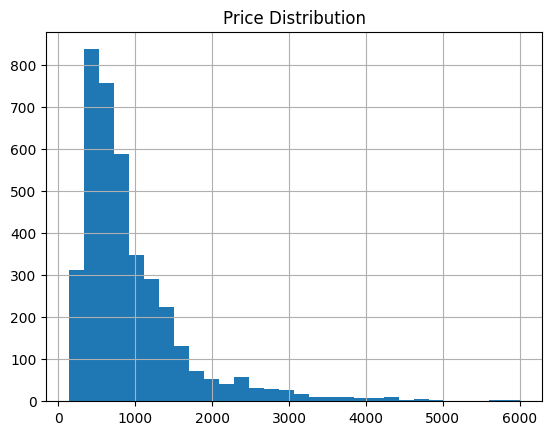

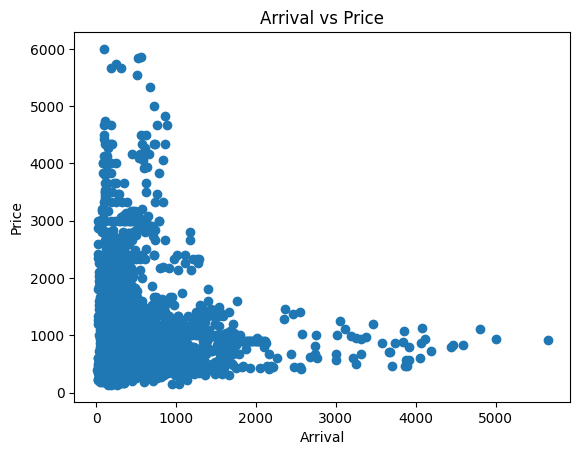

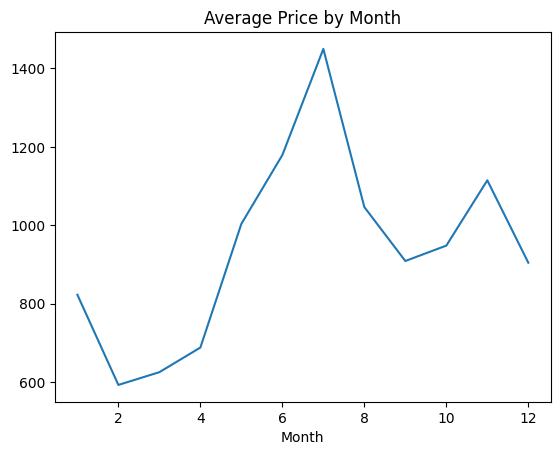

In [ ]:
train['Price'].hist(bins=30)
plt.title("Price Distribution")
plt.show()

plt.scatter(train['Arrival'], train['Price'])
plt.title("Arrival vs Price")
plt.xlabel("Arrival")
plt.ylabel("Price")
plt.show()

train.groupby('Month')['Price'].mean().plot(kind='line', title="Average Price by Month")
plt.show()


In [ ]:
train = train.sort_values("Date").reset_index(drop=True)

train['Price_lag_1'] = train['Price'].shift(1)
train['Price_lag_7'] = train['Price'].shift(7)
train['Arrival_lag_1'] = train['Arrival'].shift(1)
train['Price_roll_7'] = train['Price'].rolling(7).mean()
train['Price_roll_14'] = train['Price'].rolling(14).mean()

train = train.dropna().reset_index(drop=True)


In [ ]:
split_date = "2018-07-01"
train_data = train[train["Date"] < split_date]
val_data = train[train["Date"] >= split_date]

features = [
    "Arrival", "Year", "Month", "Day", "DayOfWeek",
    "Price_lag_1", "Price_lag_7", "Arrival_lag_1",
    "Price_roll_7", "Price_roll_14"
]

X_train = train_data[features]
y_train = np.log(train_data["Price"])

X_val = val_data[features]
y_val = np.log(val_data["Price"])

print(X_train.shape, X_val.shape)

(3821, 10) (62, 10)


In [ ]:
lgb_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.02,
    max_depth=-1,
    num_leaves=64,
    min_child_samples=20,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

lgb_model.fit(X_train, y_train)

y_val_pred_log = lgb_model.predict(X_val)
y_val_pred = np.exp(y_val_pred_log)
rmse = np.sqrt(mean_squared_error(np.exp(y_val), y_val_pred))

print("Validation RMSE:", rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1592
[LightGBM] [Info] Number of data points in the train set: 3821, number of used features: 10
[LightGBM] [Info] Start training from score 6.623092
Validation RMSE: 137.54523461646966


In [ ]:
test = test.sort_values("Date").reset_index(drop=True)

last_train = train.iloc[-14:]

combined = pd.concat([last_train, test], ignore_index=True)

history = train.copy()
predictions = []

for i in range(len(test)):
    row = test.iloc[i]

    features_row = {
        "Arrival": row["Arrival"],
        "Year": row["Year"],
        "Month": row["Month"],
        "Day": row["Day"],
        "DayOfWeek": row["DayOfWeek"],
        "Price_lag_1": history.iloc[-1]["Price"],
        "Price_lag_7": history.iloc[-7]["Price"],
        "Arrival_lag_1": history.iloc[-1]["Arrival"],
        "Price_roll_7": history["Price"].iloc[-7:].mean(),
        "Price_roll_14": history["Price"].iloc[-14:].mean(),
    }

    X_test_row = pd.DataFrame([features_row])
    pred_log = lgb_model.predict(X_test_row)[0]
    pred = np.exp(pred_log)

    predictions.append(pred)

    new_row = row.copy()
    new_row["Price"] = pred
    history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)



In [ ]:
sample_sub["Price"] = predictions
sample_sub.to_csv("submission.csv", index=False)
print("submission.csv created successfully.")

submission.csv created successfully.
